**Section 1. Data Input**

In [1]:
import pandas as pd
from google.colab import drive
import os
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Set your working directory path
base_path = "/content/drive/My_Drive/base_folder"
# Example: base_path = "/content/drive/My Drive/2024-2028 MIT PhD/Course Selection/20.440 BioNetworks/HW6"
os.chdir(base_path)

Mounted at /content/drive


**Clean Test Dataset**

In [19]:
# Define subfolder and file name
subfolder = "Data"
filename = "Test_Dataset.xlsx"

# Construct full path using os.path.join
file_path = os.path.join(base_path, subfolder, filename)

In [20]:
# Load the Excel file
test_df = pd.read_excel(file_path)

# Clean data
clean_test_df = test_df.drop_duplicates(subset=["Sequence"], keep="first")

# # Construct full path using os.path.join
# clean_df_filename = "Deduplicated_Sequences.xlsx"
# clean_df_path = os.path.join(base_path, subfolder, clean_df_filename)

# # Save deduplicated data
# clean_test_df.to_excel(clean_df_path,
#                  sheet_name="Unique_Sequences",
#                  index=False)

# Extract peptides from the "Sequence" column into a list
test_pep_list = clean_test_df["Sequence"].tolist()

In [21]:
# len(test_pep_list)

567

In [22]:
# The CD4 T cell prediction model (Model 1) doesn't take peptides smaller than 15 amino acids.
# 6 from the test set are filtered out
min_length = 15
filtered_test_pep_list = [pep for pep in test_pep_list if len(pep) >= min_length]

# Filter by length to fit the immunogenicity prediction model
filtered_test_df = clean_test_df[clean_test_df['Length'] >= 15].copy()

# Convert "N/A" strings to true NaN
filtered_test_df['Immunogenic Score'] = filtered_test_df['Immunogenic Score'].replace('N/A', np.nan)

In [23]:
# len(filtered_test_pep_list)

561

**Break Test Set and Training Sets Into Input Files of <= 1000 Sequences to Calculate Tm**

In [31]:
def process_peptide_batches_Tm(input_pep_list, batch_number=1, batch_size=1000, output_subfolder="Data"):
    """
    Processes peptide list in batches of 1000, saving each batch to a numbered file.
    Continues until all sequences are processed. Each peptide is prefixed with '>!'.

    Args:
        input_pep_list (list): List of peptide sequences to process
        batch_number (int): Starting number for batch files (default: 1)
        batch_size (int): Number of sequences per batch (default: 1000)
        output_subfolder (str): Subfolder to save batch files (default: "Data")

    Returns:
        int: Total number of batch files created
    """
    remaining_peptides = input_pep_list.copy()

    while len(remaining_peptides) > 0:
        # Take up to 1000 peptides
        current_batch = remaining_peptides[:batch_size]
        remaining_peptides = remaining_peptides[batch_size:]

        # Create filename with batch number
        filename = f"Tm_peptide_batch_{batch_number}.txt"
        output_path = os.path.join(base_path, output_subfolder, filename)

        # Save to file
        with open(output_path, 'w') as f:
            f.write('\n'.join([">!" + str(peptide) for peptide in current_batch]))

        batch_number += 1
    return batch_number - 1

In [32]:
# Calculate Tm for Test Set
batch_number = process_peptide_batches_Tm(filtered_test_pep_list, batch_number=1) # total number of files

In [33]:
# Calculate Tm for Training Set (Model 1)
Model1_train_filename = "Model1_Train_Dataset.xlsx"
Model1_train_file_path = os.path.join(base_path, subfolder, Model1_train_filename)
Model1_train_df = pd.read_excel(Model1_train_file_path)
Model1_train_pep_list = Model1_train_df["Sequence"].astype(str).tolist()  # Convert to list of strings

batch_number = process_peptide_batches_Tm(Model1_train_pep_list, batch_number=batch_number)

**Section 2. Visualize Input Datasets**

This section includes visualizations for the distribution of peptide length and melting temperature (Tm) for the input datasets. These plots can help understand the data distribution and characteristics.

In [318]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

figure_counter = 0

**Peptide Distribution In Terms of Peptide Length and Temperature Melting (Tm)**

In [319]:
def plot_peptide_distribution(input_df, dataset_name = "Test Dataset", save_figures=True):
    """
    Plots the length and Tm distribution for a given dataset.

    Args:
        input_df: DataFrame containing Length and Tm values
        dataset_name: Name of the dataset (default: "Test Dataset")
        save_figure: Whether to save the figure (default: True)

    Returns:
        int: The figure number that was used for this plot
    """
    global figure_counter
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{dataset_name} Peptide Distribution (n={len(input_df['Length'])})", y=1.05)

    # Length distribution
    sns.histplot(input_df['Length'], bins=30, kde=False,
                 color='#2073BC', edgecolor='white', linewidth=0.5, ax=ax1)  # Adjust bins as necessary
    ax1.set_title(f"Peptide Length")
    ax1.set_xlabel('Length (residues))')
    ax1.set_ylabel('Frequency')

    # Tm Distribution
    sns.histplot(input_df['Tm'], bins=30, kde=False,
                 color='#2073BC', edgecolor='white', linewidth=0.5, ax=ax2)  # Adjust bins as necessary
    ax2.set_title(f"Tm")
    ax2.set_xlabel('Tm (°C)')
    ax2.set_ylabel('Frequency')

    figure_counter += 1
    if save_figures:
        plt.savefig(f"Figures/Figure{figure_counter}_{dataset_name.replace(' ', '_')}_Peptide_Distribution.png", dpi=300, bbox_inches='tight')

    fig.tight_layout()
    fig.show()
    return figure_counter

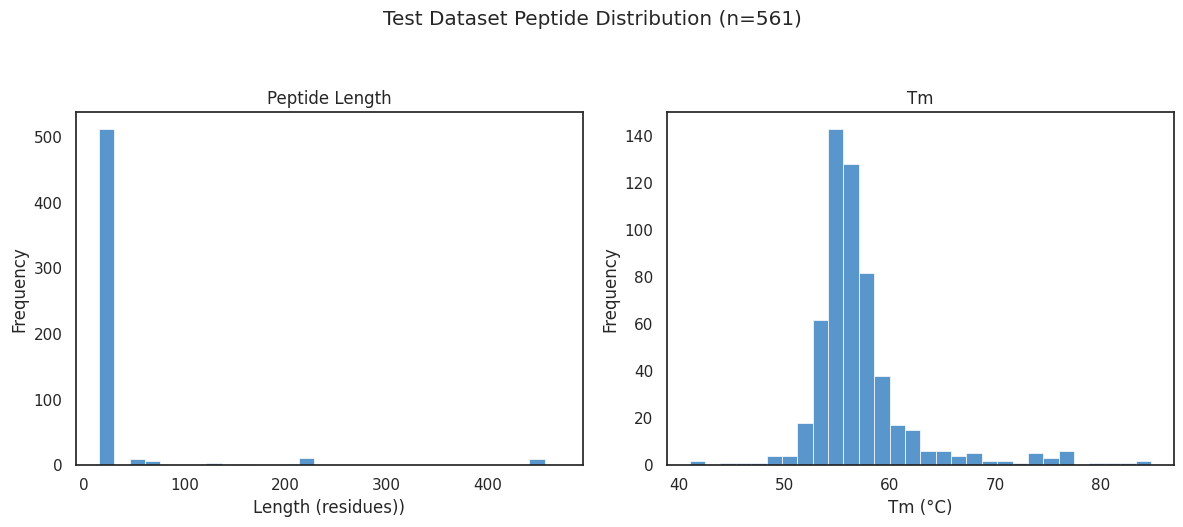

In [320]:
# Test Datatset
figure_counter = plot_peptide_distribution(filtered_test_df, dataset_name = "Test Dataset")

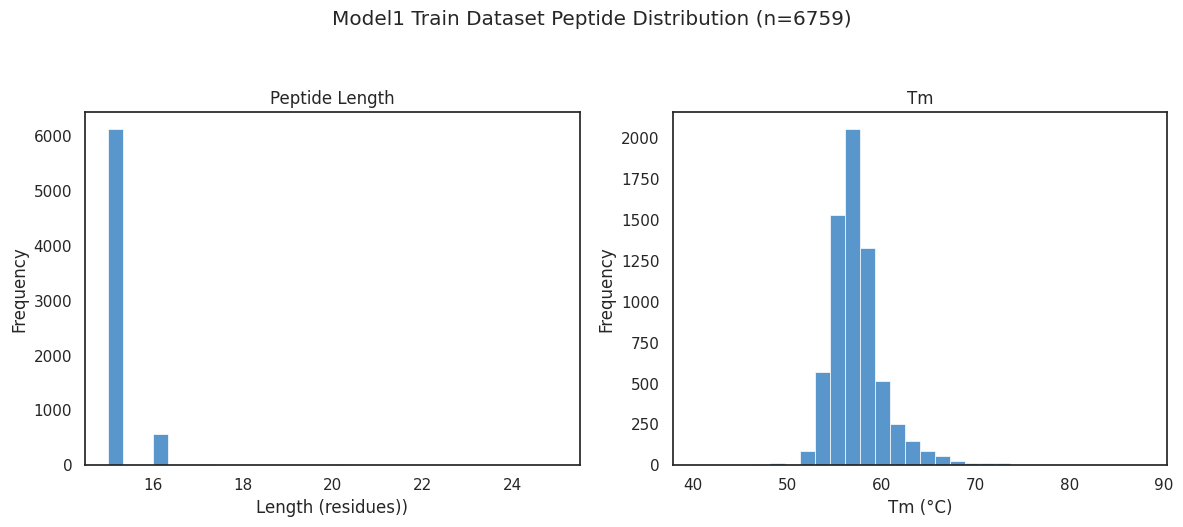

In [299]:
# Model1 Train Datatset
figure_counter = plot_peptide_distribution(Model1_train_df, dataset_name = "Model1 Train Dataset")

**Peptide Distribution In Terms of Peptide Length and Temperature Melting (Tm), with Axis Break for the Peptide Length Plot**

In [300]:
def plot_peptide_distribution_axis_break(input_df, dataset_name = "Test Dataset", save_figures=True):
    """
    Plots the length and Tm distribution for a given dataset. The length plot
    has an axis break.

    Args:
        input_df: DataFrame containing Length and Tm values
        dataset_name: Name of the dataset (default: "Test Dataset")
        save_figure: Whether to save the figure (default: True)

    Returns:
        int: The figure number that was used for this plot
    """
    global figure_counter
    fig = plt.figure(figsize=(12, 5))
    fig.suptitle(f"{dataset_name} Peptide Distribution with Axis Break (n={len(input_df['Length'])})", y=1.05)

    # Length distribution

    # Create GridSpec layout (1 row, 2 columns with custom widths)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Create nested GridSpec for broken axis
    gs_length = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],
                                           height_ratios=[1, 3], hspace=0.05)
    ax1_top = fig.add_subplot(gs_length[0])
    ax1_bottom = fig.add_subplot(gs_length[1], sharex=ax1_top)

    # Plot same data on both axes
    sns.histplot(input_df['Length'], bins=30, kde=False,
                color='#2073BC', edgecolor='white', ax=ax1_top)
    sns.histplot(input_df['Length'], bins=30, kde=False,
            color='#2073BC', edgecolor='white', ax=ax1_bottom)

    # Configure axis break
    ax1_top.set_ylim(input_df['Length'].value_counts().max()*0.8,
                input_df['Length'].value_counts().max()*1.1)
    ax1_bottom.set_ylim(0, input_df['Length'].value_counts().max()*0.2)

    # Hide spines between axes
    ax1_top.spines['bottom'].set_visible(False)
    ax1_bottom.spines['top'].set_visible(False)
    ax1_top.tick_params(bottom=False)

    # Add break marks
    d = 0.01
    kwargs = dict(transform=ax1_top.transAxes, color='k', clip_on=False)
    ax1_top.plot((-d, +d), (-d, +d), **kwargs)
    ax1_top.plot((1-d, 1+d), (-d, +d), **kwargs)

    kwargs.update(transform=ax1_bottom.transAxes)
    ax1_bottom.plot((-d, +d), (1-d, 1+d), **kwargs)
    ax1_bottom.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

    # Set labels
    ax1_top.set_title('Peptide Length')
    ax1_bottom.set_xlabel('Length (residues)')
    ax1_bottom.set_ylabel('')  # Clear y-label for ax1
    ax1_top.set_ylabel('')  # Clear y-label for ax2
    fig.text(0.005, 0.5, 'Frequency', va='center', rotation='vertical')

    # Tm Distribution
    ax2 = plt.subplot(gs[1])
    sns.histplot(input_df['Tm'], bins=30, kde=False,
                 color='#2073BC', edgecolor='white', linewidth=0.5, ax=ax2)  # Adjust bins as necessary
    ax2.set_title(f"Tm")
    ax2.set_xlabel('Tm (°C)')
    ax2.set_ylabel('Frequency')

    figure_counter += 1
    if save_figures:
        plt.savefig(f"Figures/Figure{figure_counter}_{dataset_name.replace(' ', '_')}_Peptide_Distribution_w_Axis_Break.png", dpi=300, bbox_inches='tight')

    fig.tight_layout()
    fig.show()
    return figure_counter

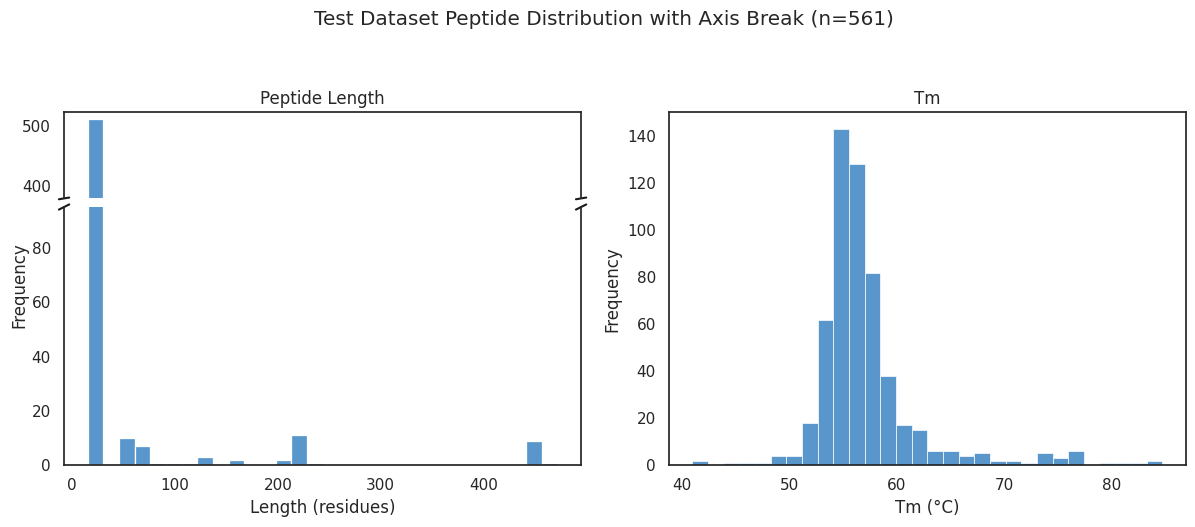

In [301]:
# Test Datatset
figure_counter = plot_peptide_distribution_axis_break(filtered_test_df, dataset_name = "Test Dataset")

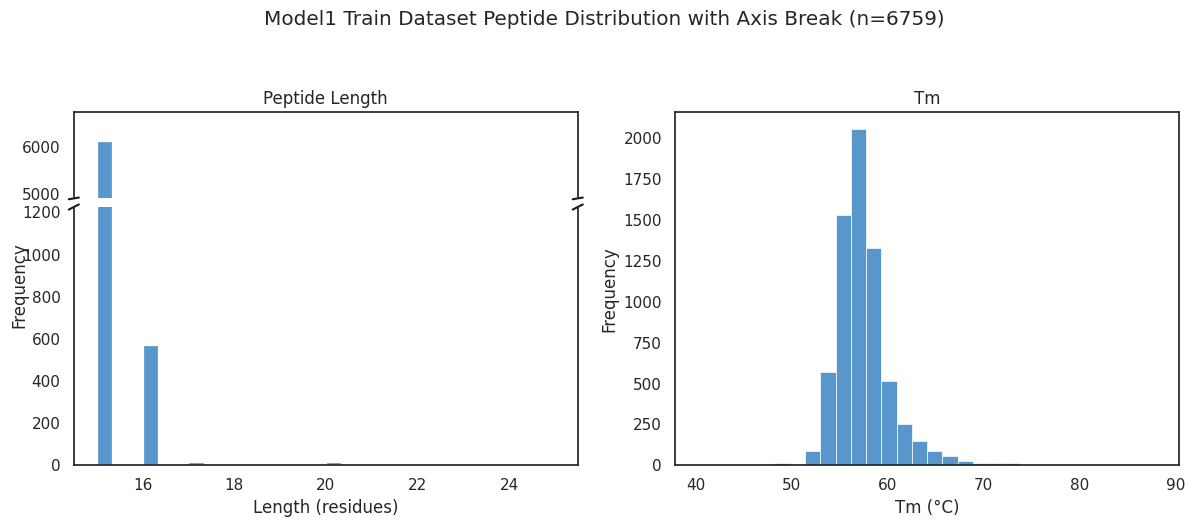

In [302]:
# Model1 Train Datatset
figure_counter = plot_peptide_distribution_axis_break(Model1_train_df, dataset_name = "Model1 Train Dataset")

**Visualize *De Novo* Proteins' Tm Distribution**

This is to specifically visualize the Tm distribution of *de novo* proteins (within the test dataset)

In [303]:
def visualize_de_novo_tm_distribution(input_df, dataset_name = "Test Dataset", save_figures=True):
    """
    Visualizes Tm distribution of de novo proteins as a strip plot with range indicator.

    Args:
        input_df: DataFrame containing Tm values
        dataset_name: Name of the dataset (default: "Test Dataset")
        save_figure: Whether to save the figure (default: True)

    Returns:
        int: The figure number that was used for this plot
    """
    global figure_counter

    # Extract de novo proteins from the dataset
    de_novo_proteins = input_df[input_df['Category'] == 'de novo, not tested in humans']

    # Create a figure for Tm distribution of de novo proteins
    plt.figure(figsize=(12, 2))

    # Create a strip plot to show the distribution of Tm temperatures
    plt.scatter(de_novo_proteins['Tm'], [1] * len(de_novo_proteins), alpha=0.6, color='#2073BC')  # Dots along a single Y value

    # Draw a horizontal line for the overall temperature range
    plt.hlines(1, de_novo_proteins['Tm'].min(), de_novo_proteins['Tm'].max(), colors='gray', linestyles='dashed')

    # Customize the plot
    plt.title(f'Temperature Range of De Novo Proteins in {dataset_name}')
    plt.xlabel('Tm (°C)')
    plt.yticks([])  # Remove Y ticks since they are not needed
    plt.xlim(de_novo_proteins['Tm'].min(), de_novo_proteins['Tm'].max())  # Set x-axis limits to the temperature range
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability
    plt.tight_layout()
    figure_counter += 1
    if save_figures:
        plt.savefig(f"Figures/Figure{figure_counter}_De_Novo_Proteins'_Tm_Distribution_in_{dataset_name.replace(' ','_')}.png", dpi=300, bbox_inches='tight')

    plt.show()
    return figure_counter

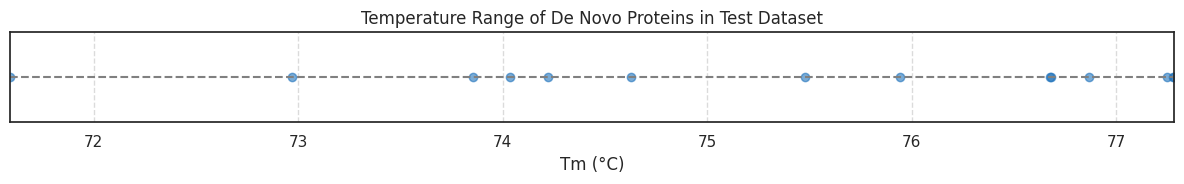

In [304]:
figure_counter = visualize_de_novo_tm_distribution(filtered_test_df, dataset_name = "Test Dataset")

**Section 3. Run Models**

**Before Running Immunogenicity Prediction Model (Model 1), Break Test Set Into Input Files of <= 100 Sequences**

In [305]:
def process_peptide_batches(input_pep_list, batch_size=100, output_subfolder="Data", model_number=1):
    """
    Processes peptide list in batches of 100, saving each batch to a numbered file.
    Continues until all sequences are processed.

    Args:
        input_pep_list (list): List of peptide sequences to process
        batch_size (int): Number of sequences per batch (default: 100)
        output_subfolder (str): Subfolder to save batch files (default: "Data")
        model_number (int): Model identifier to include in filenames (default: 1)

    Returns:
        int: Total number of batch files created
    """
    batch_number = 1
    remaining_peptides = input_pep_list.copy()

    while len(remaining_peptides) > 0:
        # Take up to 100 peptides
        current_batch = remaining_peptides[:batch_size]
        remaining_peptides = remaining_peptides[batch_size:]

        # Create filename with batch number
        filename = f"Model{model_number}_peptide_batch_{batch_number}.txt"
        output_path = os.path.join(base_path, output_subfolder, filename)

        # Save to file
        with open(output_path, 'w') as f:
            f.write('\n'.join(current_batch))

        batch_number += 1
    return batch_number - 1

In [306]:
# Calculate Immunogenicity Prediction Score for Test Set
batch_number = process_peptide_batches(filtered_test_pep_list) # total number of files

**Clean Model1 Prediction Scores for Test Set**

In [307]:
def process_model1_prediction(base_filename="CD4_Prediction", total_length=len(filtered_test_pep_list), subfolder="Data", model_number=1):
    """
    Processes CD4_Prediction files to obtain a binary immunogenicity list.

    Args:
        base_filename (str): Base filename (e.g., "CD4_Prediction")
        total_length (int): Total length of the output list (561 by default)
        subfolder (str): Subfolder containing prediction files (default: "Data")
        model_number (int): Model identifier to include in filenames (default: 1)

    Returns:
        list: Binary list where 1 = immunogenic, 0 = non-immunogenic
    """
    # Initialize all positions as 0 (non-immunogenic)
    immunogenicity = [0] * total_length

    # Process files 1 through the total number of files
    for file_num in range(1, batch_number):
        filename = f"{base_filename}_{file_num}.csv"
        read_file_path = os.path.join(base_path, subfolder, filename)

        # Read the CSV file
        df = pd.read_csv(read_file_path)

        # Get protein numbers (assuming they're in a column named 'protein_number')
        protein_numbers = df['Protein Number'].unique()  # Remove duplicates

        # Adjust numbering for files > 1
        if file_num > 1:
            protein_numbers = [(num + (file_num - 1) * 100) for num in protein_numbers]

        # Mark these positions as immunogenic (1)
        for num in protein_numbers:
            if 1 <= num <= total_length:
                immunogenicity[num - 1] = 1  # -1 because Python is 0-indexed

    # Add the new column
    filtered_test_df[f"Model{model_number}"] = immunogenicity

    # output_filename = "Immunogenicity_Predicted_Sequences.xlsx"
    # output_path = os.path.join(base_path, subfolder, output_filename)
    # filtered_test_df.to_excel(output_path, index=False)

    return immunogenicity

In [308]:
immunogenicity_lst = process_model1_prediction()

**Section 4. Model Performance**

In [309]:
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix

**Quantify Model1 Performance on Controls**

In [310]:
def immunogenicity_model_metrics(y_true, y_pred, model_number=1, save_figures=True):
    """
    Generates and visualizes key performance metrics and confusion matrix for
    an immunogenicity prediction model. Two figures are produced:
            - Figure 1: Bar plot of balanced accuracy and F1-score
            - Figure 2: Confusion matrix visualization

    Args:
        y_true (array-like): Ground truth (correct) target values (0=non-immunogenic, 1=immunogenic)
        y_pred (array-like): Estimated targets as returned by a classifier
        model_number (int): Identifier for the model being evaluated (default: 1)
        save_figures (bool): Whether to save figures to 'Figures' subfolder (default: True)

    Returns:
        int: The global figure counter after creating figures (for maintaining sequential numbering)
    """
    global figure_counter

    # Calculate metrics
    metrics = {
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)}

    # Metric barplot
    fig1, ax1 = plt.subplots(figsize=(3, 4))
    bars = ax1.bar(
        metrics.keys(),
        metrics.values(),
        color = ['#2073BC', '#2073BC'],
        width=0.6)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/4., height,
                f'{height:.3f}',
                ha='left', va='bottom', fontsize=12)
    ax1.set_title(f'Model {model_number}: Performance Metrics (n={len(y_true)})', pad=20, fontsize=14)
    ax1.set_ylabel('Score', fontsize=12)
    sns.despine()
    fig1.tight_layout()
    figure_counter += 1
    if save_figures:
        fig1.savefig(f"Figures/Figure{figure_counter}_Model_{model_number}_Metrics.png", dpi=300, bbox_inches='tight')

    # # Create metric table
    # metric_df = pd.DataFrame([metrics]).T.reset_index()
    # metric_df.columns = ['Metric', 'Value']
    # metric_df['Value'] = metric_df['Value'].map('{:.3f}'.format)

    # Create confusion matrix with annotations
    cm = confusion_matrix(y_true, y_pred)
    fig2, ax2 = plt.subplots(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                xticklabels=['Pred Non-Imm', 'Pred Imm'],
                yticklabels=['True Non-Imm', 'True Imm'])
    ax2.set_title(
        f"Model {model_number}: Confusion Matrix (n={len(y_true)})", pad=20, fontsize=12)
    fig2.tight_layout()
    figure_counter += 1

    if save_figures:
        fig2.savefig(f"Figures/Figure{figure_counter}_Model_{model_number}_Confusion_Matrix.png", dpi=300, bbox_inches='tight')

    fig1.show()
    fig2.show()
    return figure_counter

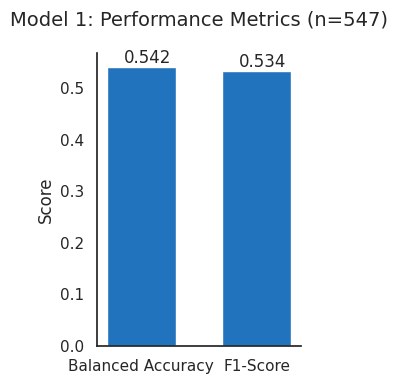

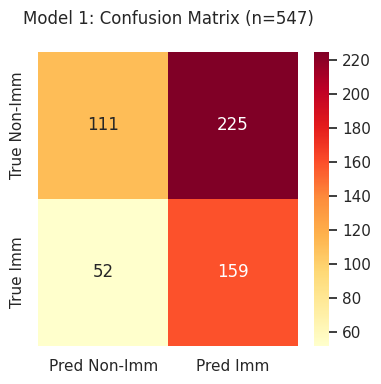

In [311]:
non_na_idx = filtered_test_df["Immunogenic Score"].notna()
y_true = filtered_test_df.loc[non_na_idx, "Immunogenic Score"]
y_pred = filtered_test_df.loc[non_na_idx, "Model1"]

figure_counter = immunogenicity_model_metrics(y_true, y_pred, model_number=1)

**Quantify Model1 Prediction on *De Novo* Proteins**

In [312]:
def de_novo_protein_predictions(input_df, model_name="Model 1", save_figures=True):
    """
    Generates and displays a bar plot of immunogenicity predictions for de novo proteins

    Args:
        input_df: DataFrame containing prediction results with columns:
                    - 'Immunogenic Score' (NA for de novo proteins)
                    - 'Model1' (prediction values 0/1)
        model_name: Name of the model to display in title (default: "Model 1")
        save_figure: Whether to save the figure to 'Figures' subfolder (default: True)

    Returns:
        int: The global figure counter after creating this figure
    """
    global figure_counter

    na_idx = input_df['Immunogenic Score'].isna()
    y_vals = input_df.loc[na_idx, "Model1"]

    pred_counts = {
        'Non-Immunogenic': (y_vals == 0).sum(),
        'Immunogenic': (y_vals == 1).sum()
    }

    fig, ax = plt.subplots(figsize=(2.5, 4))
    categories = ['Non-Immunogenic', 'Immunogenic']
    bars = ax.bar(
        categories,
        [max(0.1, pred_counts[c]) for c in categories],  # Visual minimum height
        color=['#6BACE6', '#2073BC'],
        width=0.6)

    for bar, category in zip(bars, categories):
        ax.text(bar.get_x() + bar.get_width()/4.,
                bar.get_height(),
                f'{pred_counts[category]}',
                ha='left',
                va='bottom',
                fontsize=12,
                color='black')

    ax.set_title(
        f"{model_name}: Immunogenicity Prediction of De Novo Proteins (n={len(y_vals)})",
        pad=15, fontsize=12)
    ax.set_ylabel('Count', fontsize=10)
    plt.setp(ax.get_xticklabels(), rotation=15, ha='right')
    sns.despine()
    plt.tight_layout()
    figure_counter += 1

    if save_figures:
        plt.savefig(f"Figures/Figure{figure_counter}_{model_name.replace(' ', '_')}_De_Novo_Predictions.png", dpi=300, bbox_inches='tight')

    plt.show()
    return figure_counter

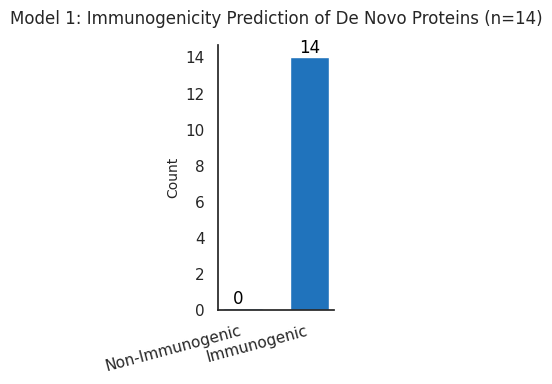

In [313]:
figure_counter = de_novo_protein_predictions(filtered_test_df, model_name="Model 1")

**Section 5. Model Similarity via Euclidean Distance**

In [314]:
from sklearn.preprocessing import StandardScaler

In [316]:
def compute_pairwise_distances(train_df, test_df, column_names=['Length', 'Tm'], model_number=1, save_figures=True):
    """
    Computes Euclidean distance between test and train data for two features,
    with equal weighting (1:1) after standardization.

    Args:
        train_df (pd.DataFrame): Training data
        test_df (pd.DataFrame): Test data
        column_names (list): Features to include (default: ['Length', 'Tm'])
        model_number: Identifier for the model being evaluated (default: 1)
        save_figures: Whether to save visualization to 'Figures' subfolder (default: True)

    Returns:
        tuple: (combined_distances, figure_counter) containing:
            - combined_distances: Array of combined Euclidean distances (shape: len(test_df))
            - figure_counter: Updated global figure counter after creating this figure
    """
    global figure_counter

    # Standardize features (mean=0, std=1) to ensure 1:1 weighting
    scaler = StandardScaler().fit(test_df[column_names])
    train_scaled = scaler.transform(train_df[column_names])
    test_scaled = scaler.transform(test_df[column_names])

    # Compute Euclidean distance for each test point vs. all train points
    distances = np.zeros((len(test_df), len(column_names)))
    combined_distances = np.zeros(len(test_df))

    for j, feature in enumerate(column_names):
        for i, test_point in enumerate(test_scaled):
            distances[i,j] = np.linalg.norm(train_scaled[:,j] - test_point[j])

    combined_distances = np.linalg.norm(distances, axis=1)

    plt.figure(figsize=(10, 6))
    # Plot Model {model_number} training data
    plt.scatter(
        train_scaled[:, 0], train_scaled[:, 1],
        c='blue', label=f'Model {model_number} (Train)', alpha=0.7, s=100
    )

    # Plot test data (colored by distance to Model {model_number})
    scatter = plt.scatter(
        test_scaled[:, 0], test_scaled[:, 1],
        c=combined_distances, cmap='Reds',
        label='Test Data', s=100, edgecolor='black'
    )

    # Add colorbar for distances
    plt.colorbar(scatter, label=f'Distance to Model {model_number}')

    # Customize plot
    plt.xlabel('Tm (Standardized)')
    plt.ylabel('Length (Standardized)')
    plt.title(f'Similarity of Test Data vs. Model {model_number}')
    plt.legend()
    figure_counter += 1

    if save_figures:
        plt.savefig(f"Figures/Figure{figure_counter}_Similarity_of_Test_Dataset_vs_Model_{model_number}.png", dpi=300, bbox_inches='tight')

    plt.show()

    return combined_distances, figure_counter

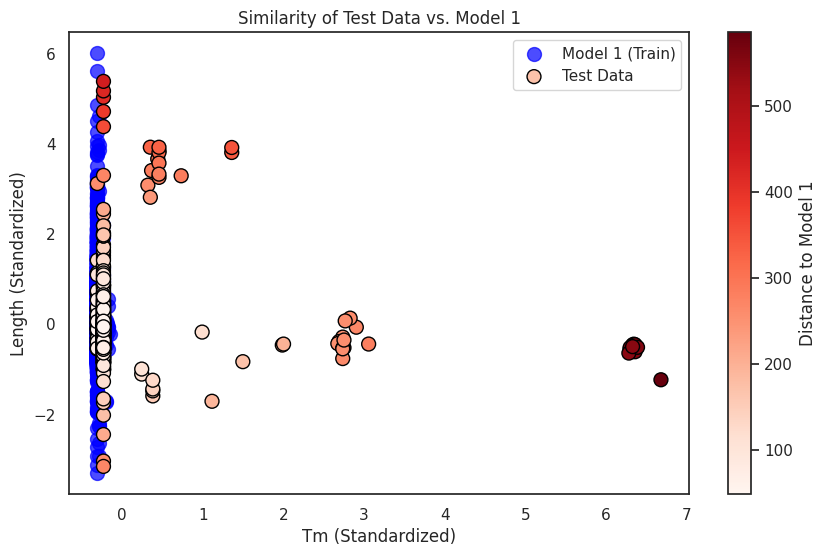

In [317]:
combined_distances_Model1, figure_counter = compute_pairwise_distances(Model1_train_df, filtered_test_df)

In [79]:
# print(combined_distances_Model1)

[171.88480407 199.04575975 199.86643197 548.9864697  258.39714958
 268.39530171 552.55304092 256.12397829 262.15593186 253.45197583
 547.0857454  260.11674188 546.87659081 258.97865068 550.12662245
 257.13068693 546.5717511  252.77256345 283.43672643 259.0414555
 551.4410192  263.1962642  554.31407745 259.2798013  549.2241874
 257.97597711  54.48658607  50.01517105 153.91958186 145.96914495
 115.80750202 257.17577877 122.80952548  49.229052    50.31310857
  51.25240397  53.51629233  50.45639161  50.18283579 101.96268015
  52.44496777  49.47703512  71.37157401  57.02322332  60.6192222
  99.14520633  53.34247082 585.70413964 191.95884487  56.02681781
  48.97424778  49.53661914  50.14187556 142.98323258 129.64451393
 108.43875318  49.26280476  74.95167264  49.16516873  50.00240936
  69.31689396  50.66424681  68.13381785 118.75924309  48.95263584
  57.22383805  63.388849    50.75148042  64.75455867  48.95970502
  61.00193593  68.48824927 322.01211107 259.43295351 341.53214982
 349.79715451